In [1]:
pip install --upgrade wandb

Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.8.36)


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import wandb 
from wandb import magic
from wandb.keras import WandbCallback

In [3]:
! wandb login a1a135dba2ad0ac1ee618e76f4cbd126c1bf6325

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
train_norm_dir = os.path.join('/content/drive/My Drive/chest-xray-pneumonia/train/NORMAL/')
train_pneu_dir = os.path.join('/content/drive/My Drive/chest-xray-pneumonia/train/PNEUMONIA/')

val_norm_dir = os.path.join('/content/drive/My Drive/chest-xray-pneumonia/test/NORMAL/')
val_pneu_dir = os.path.join('/content/drive/My Drive/chest-xray-pneumonia/test/PNEUMONIA/')

In [5]:
train_norm_names = os.listdir(train_norm_dir)
train_pneu_names = os.listdir(train_pneu_dir)

val_norm_names = os.listdir(val_norm_dir)
val_pneu_names = os.listdir(val_pneu_dir)
print(len(train_norm_names))
print(len(train_pneu_names))
print(len(val_norm_names))
print(len(val_pneu_names))

1342
3886
234
390


In [0]:
from tensorflow.keras.applications.densenet import DenseNet201

In [7]:
pre_model= DenseNet201(include_top=False,
                             weights='imagenet',
                             input_shape=(224,224,3))

74842112/74836368 [==============================] - 1s 0us/step


In [0]:
for layer in pre_model.layers:
  layer.trainable=True

In [9]:
pre_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [0]:
#last_layer = pre_model.get_layer('mixed_5b')
last_output = pre_model.output

In [0]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
#x = tf.keras.layers.AveragePooling2D((4,4))(last_output)
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(256,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
#x = tf.keras.layers.Dense(512,activation= 'relu')(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2,activation='softmax')(x)

In [0]:
model = tf.keras.Model(pre_model.input,x)

In [0]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                   rotation_range=20,
                                   brightness_range=[0.7,1.2],
                                   zoom_range=0.2
                                  )
val_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/chest-xray-pneumonia/train',
                                                    batch_size = 16,
                                                    class_mode='categorical',
                                                    target_size=(224,224))

val_generator = val_datagen.flow_from_directory('/content/drive/My Drive/chest-xray-pneumonia/test',
                                                    batch_size = 16,
                                                    class_mode='categorical',
                                                    target_size=(224,224))


Found 5226 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [29]:
wandb.init(project="chest_pneumonia")
history = model.fit(train_generator,
                              validation_data=val_generator,
                              steps_per_epoch=326,
                       validation_steps=val_generator.samples//val_generator.batch_size,
                              epochs=25,callbacks=[WandbCallback()]
                    )

Epoch 1/25
326/326 [==============================] - 7963s 24s/step - loss: 0.2411 - accuracy: 0.9335 - val_loss: 1.2702 - val_accuracy: 0.7260
Epoch 2/25
326/326 [==============================] - 283s 867ms/step - loss: 0.0974 - accuracy: 0.9674 - val_loss: 0.5615 - val_accuracy: 0.8622
Epoch 3/25
326/326 [==============================] - 279s 857ms/step - loss: 0.0725 - accuracy: 0.9770 - val_loss: 0.7303 - val_accuracy: 0.8125
Epoch 4/25
326/326 [==============================] - 283s 868ms/step - loss: 0.0551 - accuracy: 0.9797 - val_loss: 0.2844 - val_accuracy: 0.9471
Epoch 5/25
326/326 [==============================] - 284s 871ms/step - loss: 0.0579 - accuracy: 0.9804 - val_loss: 0.1645 - val_accuracy: 0.9391
Epoch 6/25
326/326 [==============================] - 279s 857ms/step - loss: 0.0535 - accuracy: 0.9821 - val_loss: 0.4675 - val_accuracy: 0.9006
Epoch 7/25
326/326 [==============================] - 279s 856ms/step - loss: 0.0425 - accuracy: 0.9846 - val_loss: 0.7657 - 

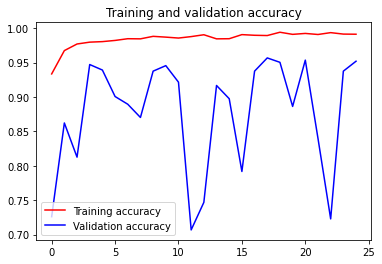

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [33]:
import cv2
from imutils import paths
import numpy as np

print("[INFO] loading images...")
imagePaths = list(paths.list_images("/content/drive/My Drive/chest-xray-pneumonia/test"))
data = []
labels = []

for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
 
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
print(len(data))
print(labels)

data = np.array(data) / 255.0
labels = np.array(labels)
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

(trX, tsX, trY, tsY) = train_test_split(data, labels,
	test_size=0.9, stratify=labels, random_state=42)



[INFO] loading images...
624
['PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMON

Using TensorFlow backend.


In [34]:
print("[INFO] evaluating network...")
predIdxs = model.predict(tsX, batch_size=16)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(tsY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

      NORMAL       0.97      0.91      0.94       211
   PNEUMONIA       0.95      0.98      0.96       351

    accuracy                           0.95       562
   macro avg       0.96      0.94      0.95       562
weighted avg       0.95      0.95      0.95       562



In [42]:
from PIL import Image, ImageOps
import cv2
from google.colab import files

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  image = cv2.imread(path)
  size = (224, 224)
  image = cv2.resize(image,size)

  image_array = np.asarray(image)
  normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
  data[0] = normalized_image_array
  prediction = model.predict(data)

  acc = str(prediction[0][prediction[0].argmax()]*100) + "%"
  output = str(['NORMAL','PNEUMONIA'][prediction[0].argmax()])
  # print(fn)
  print(prediction)
  print(output+"  "+acc)

Saving datasets_519493_955640_images_images_TEST_nx10.jpg to datasets_519493_955640_images_images_TEST_nx10.jpg
Saving datasets_519493_955640_images_images_TEST_nx11.jpg to datasets_519493_955640_images_images_TEST_nx11.jpg
Saving datasets_519493_955640_images_images_TEST_nx12.jpg to datasets_519493_955640_images_images_TEST_nx12.jpg
Saving datasets_519493_955640_images_images_TEST_nx17.jpg to datasets_519493_955640_images_images_TEST_nx17.jpg
[[0.00108588 0.9989141 ]]
PNEUMONIA  99.8914122581482%
[[0.9258843 0.0741157]]
NORMAL  92.58843064308167%
[[0.8149234  0.18507655]]
NORMAL  81.49234056472778%
[[0.987415   0.01258501]]
NORMAL  98.74150156974792%
